In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

In [2]:
monthly_sales_of_company = pd.read_csv("C:/DS/Netology/TS/Series/monthly-sales-of-company-x-jan-6.csv")

In [3]:
monthly_sales_of_company.sample(5)

,Month,Count
5,1965-06,59
69,1970-10,858
9,1965-10,278
7,1965-08,169
0,1965-01,154


In [4]:
female_births = pd.read_csv("C:/DS/Netology/TS/Series/daily-total-female-births-in-cal.csv")

In [5]:
female_births.sample(5)

,Date,Count
239,1959-08-28,42
132,1959-05-13,42
251,1959-09-09,57
244,1959-09-02,68
220,1959-08-09,44


Функции, которые будем использовать

In [6]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)
        
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

def mse_dema(X):
    alpha, beta = X
    result =double_ema_with_preds(train, alpha, beta, n_preds)[0]
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

def mse_ema(X):
    alpha = X
    result =exponential_moving_average(train, alpha, n_preds)[0]
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

Выберем один стационарный и один нестационарный ряд \
Нестационарный - monthly sales of company \
Стационарный - female births

# 1. Monthly sales of company X

Проверим первичиный ряд на стационарность тестом Дикки-Фуллера

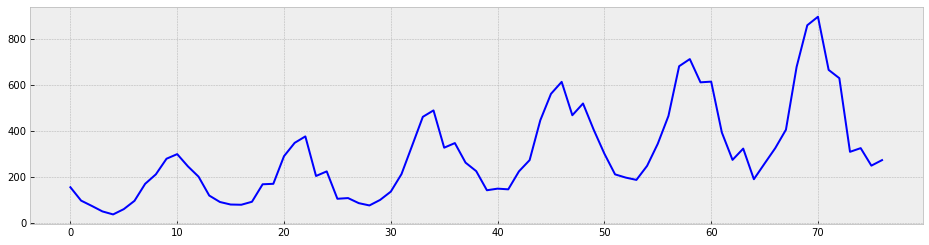

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    x = range(len(monthly_sales_of_company))
    y = monthly_sales_of_company['Count']
    plt.plot(x,y, color='blue')

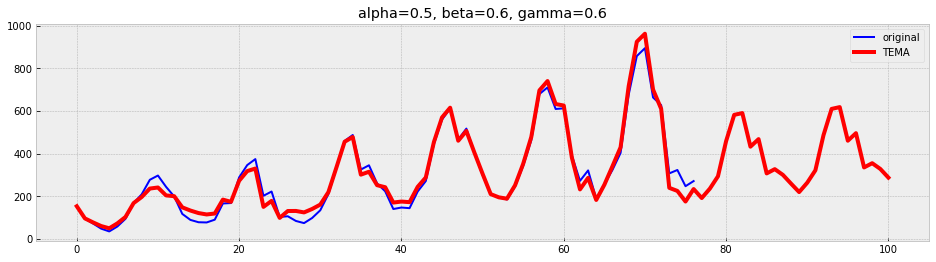

In [9]:
alpha = 0.5
beta = 0.6
gamma = 0.6
timeset = monthly_sales_of_company["Count"]
slen = 12
n_preds = 24

tema = triple_exponential_smoothing(timeset, slen, alpha, beta, gamma, n_preds)

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    x = range(len(monthly_sales_of_company))
    y = monthly_sales_of_company['Count']
    plt.plot(x, y, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

Используем RMSE для подбора альфа, бэтта, гамма (диапазон от 0 до 1)

In [11]:
series = monthly_sales_of_company["Count"]
train, test, val = series[:60], series[60:70], series[70:]
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 2932.0911896048847
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.91127139e-02, -5.60248737e-02, -1.01783493e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 27
     njev: 45
   status: 0
  success: True
        x: array([0.26928439, 0.12265085, 1.        ])


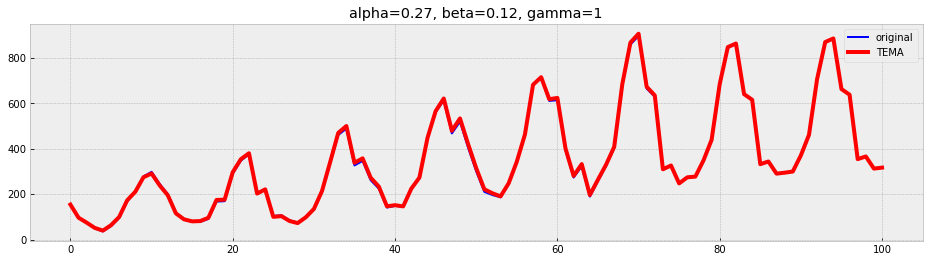

In [14]:
alpha = 0.27
beta = 0.12
gamma = 1
timeset = monthly_sales_of_company["Count"]
slen = 12
n_preds = 24

tema = triple_exponential_smoothing(timeset, slen, alpha, beta, gamma, n_preds)

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    x = range(len(monthly_sales_of_company))
    y = monthly_sales_of_company['Count']
    plt.plot(x, y, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

# 2. Ffemale births

Используем метод EMA, так как в ряду нет ни тредов, ни сезоности.

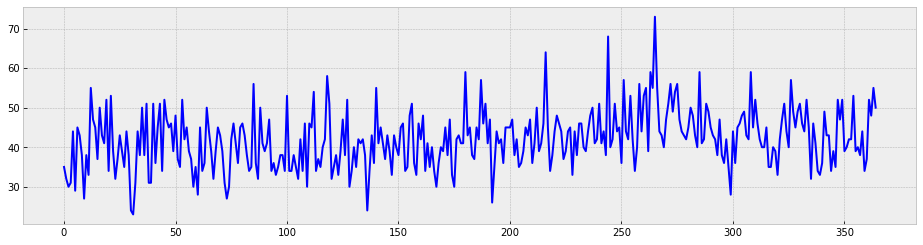

In [15]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    x = range(len(female_births))
    y = female_births['Count']
    plt.plot(x,y, color='blue')

C:\Users\chizm\AppData\Local\Temp\ipykernel_14932\4037442831.py:29: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)


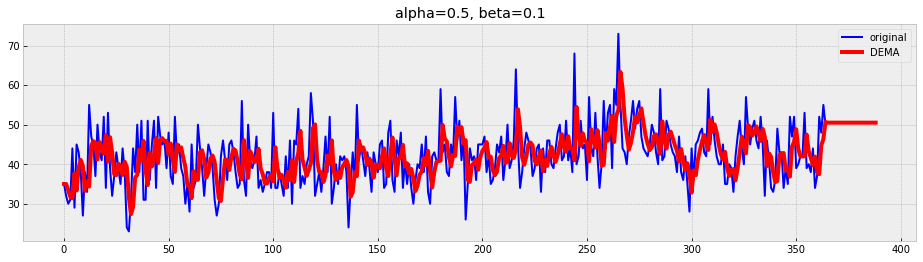

In [18]:
alpha = 0.5
timeset = female_births['Count']
n_preds = 24

ema = exponential_moving_average(timeset, alpha, n_preds)[1]

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    x = range(len(female_births))
    y = female_births['Count']
    plt.plot(x, y, color='blue',label='original')
    plt.plot(ema, color='red', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()